## 4.5 权重衰减
我们总是可以去收集更多的训练数据来缓解过拟合。但是这会导致成本很高，耗时颇多。假设我们已经拥有了尽可能多的高质量数据，我们便可以将重点放在正则化技术上。

回想一下，在多项式回归的例子中，我们可以通过调整拟合多项式的阶数来限制模型的容量。实际上，限制特征的数量是缓解过拟合的一种常用技术。简单地丢弃特征对于这项工作来说可能过于生硬。我们继续思考多项式回归的例子，考虑高维输入可能发生的情况。多项式对多变量数据的自然扩展称为单项式(monomials)，也可以说是变量幂的乘积。单项式的阶数是幂的和。

注意，随着阶数$d$的增长，带有阶数$d$的项数迅速增加。给定$k$个变量，阶数$d$(即$k$多选$d$)的个数$(^{k-1+d}_{k-1})$。即使是阶数上的微小变化，比如从2到3，也会显著增加我们模型的复杂性。因此。我们经常需要一个更细粒度的工具来调整函数的复杂性。

### 4.5.1 范数与权重衰减

在之前，我们已经描述了$L_2$范数和$L_1$范数，它们是更为一般的$L_p$范数的特殊情况

在训练参数化机器学习模型时，权重衰减(weight decay)是最广泛使用的正则化的技术之一，它通常也被称为$L_2$正则化。这项技术通过函数与0的距离来衡量函数的复杂度，因为在所有函数$f$中，函数$f=0$(所有输入都得到值0)在某种意义上是最简单的。函数分析和巴拿赫空间理论的研究，都在致力于精确测量一个函数和零之间的距离。

一种简单的方法是通过线性函数$f(x) = w^T x$中的权重向量的某个范数来度量其复杂性，例如$\mid \mid w \mid \mid ^2$。要保证权重向量比较小，最常用方法是将其范数作为惩罚项加到最小化损失的问题。将原来的训练目标最小化训练标签上的预测损失，调整为最小化预测损失和惩罚项之和。现在，如果我们的权重向量增长的太大，我们的学习算法可能更集中最小化权重范数$\mid \mid w \mid \mid^2$。我们的损失由下式给出：
$$
L(w, b) = \frac {1}{n} \sum_{i=1}^{n} \frac{1}{2} (w^T x^{(i)} + b - y^{(i)})^2
$$

回想一下，$x^{(i)}$是样本$i$的特征，$y^{(i)}$是样本$i$的标签，$(w, b)$是权重和偏置参数。为了惩罚权重向量的大小，我们必须以某种方式在损失函数中添加$\mid \mid w \mid \mid ^2$，但是模型应该如何平衡这个新的额外惩罚的损失？我们通过正则化常数$\lambda$来描述这种权衡，这是一个非负超参数，我们使用验证数据拟合：
$$
L(w, b) + \frac{\lambda}{2} \mid \mid w \mid \mid ^2
$$

对于$\lambda = 0$，我们恢复了原来的损失函数。对于$\lambda > 0$，我们限制$\mid \mid w \mid \mid$的大小。这里我们仍然除以2:当我们取一个二次函数的导数时，2和1/2会抵消，以确保更新表达式看起来既漂亮又简单。为了方便计算，通过平方$L_2$范数，我们去掉平方根，留下权重向量每个分量的平方和。这使得惩罚的导数很容易计算：导数的和等于和的导数。

这个选择在整个统计领域中都是有效的和受欢迎的。$L_2$正则化线性模型构成经典的岭回归(ridge regression)算法，$L_1$正则化线性回归是统计学中类似的基本模型，通常被称为套索回归(lasso regression)。使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使我们的学习算法偏向于大量特征上均匀分布权重的模型。在实践中，这而将其他权重清楚为零。这称为特征选择(feature selection)，这可能是其他场景下需要的。

$L_2$正则化回归的小批量随机梯度下降更新如下式：
$$
w \leftarrow (1 - \eta \lambda) w - \frac{\eta}{\mid B \mid} \sum_{i \in B} x^{(i)} (W^T x^{(i)} + b - y^{(i)})
$$

我们根据估计值与观测值之间的差异来更新$w$。然而，我们同时也在试图将$w$的大小缩小为零。我们仅考虑惩罚项，优化算法在训练的每一步衰减权重。与特征选择相比，权重衰减提供了一种连续的机制来调整函数的复杂度。较小的$\lambda$值对应较少约束的$w$，而较大的值对$\lambda$的约束更大。

是否相应的偏置$b^2$进行惩罚在不同的实践中会有所不同，在神经网络的不同层中也会有所不同。通常，网络输出层的偏置项不会被正则化。

### 4.5.2 高维线性回归

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

首先，我们像以前一样生成一些数据，生成公式如下：
$$
y = 0.05 + \sum_{i=1}^d 0.01 x_i + \epsilon where \epsilon \sim \mathcal N(0, 0.01^2)
$$

我们选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d=200$，并使用一个只包含20个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

### 4.5.3 从零开始实现
下面我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。

**初始化模型** 

首先，我们将定义一个函数来随机初始化模型参数。

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

**定义L_2范数惩罚**

实现这一惩罚最方便的方法是对所有项求平方后将它们求和

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

**定义训练代码实现**

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。线性网络和平方损失没有变化，所以我们通过`d2l.linreg`和`d2l.squared_loss`导入它们。唯一的变化是损失现在包括了惩罚项。

In [7]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                        xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:
            #增加L2范数惩罚项
            #广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)

        if (epoch + 1) % 5 == 0:
            animator.add(epoch+1, (d2l.evaluate_loss(net, train_iter, loss),
                                    d2l.evaluate_loss(net, test_iter, loss)))

    print('w的L2范数是: ', torch.norm(w).item())

**忽略正则化直接训练**

我们现在用`lambd=0`禁用权重衰减后运行代码。

w的L2范数是:  13.091922760009766


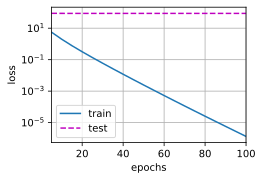

In [8]:
train(lambd=0)

**使用权重衰减**

w的L2范数是:  0.37361574172973633


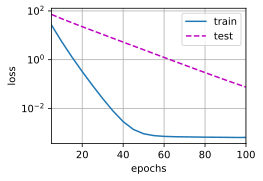

In [9]:
train(lambd=3)

### 4.5.4 简洁实现
由于权重衰减在神经网络优化中很常见，深度学习框架为了便于我们使用权重衰减，将权重衰减集成到优化算法中，以便与任何损失函数结合使用。此外，这种集成还有计算上的好处，允许不在增加任何额外的计算开销的情况下向算法中添加权重衰减。由于更新的权重衰减部分依赖于每个参数的当前值，因此优化器必须至少接触每个参数一次。

在下面的代码中，我们在实例化优化器时直接通过`weight_decay`指定`weight_decay`超参数。默认情况下，PyTorch同时衰减权重和偏移。这里我们只为权重设置了`weight_decay`，所以偏置参数$b$不会衰减

In [12]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    #偏置参数没有衰减
    trainer = torch.optim.SGD([
        {'params': net[0].weight, 'weight_decay': wd},
        {'params': net[0].bias}
    ], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()

        if (epoch + 1)%5 == 0:
            animator.add(epoch+1, 
                                (d2l.evaluate_loss(net, train_iter, loss),
                                d2l.evaluate_loss(net, test_iter, loss)))
    
    print('w的L2范数: ',net[0].weight.norm().item())

w的L2范数:  13.832281112670898


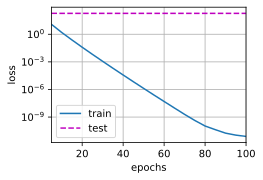

In [13]:
train_concise(0)

w的L2范数:  0.3618055284023285


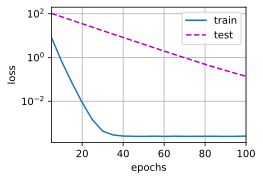

In [14]:
train_concise(3)

到目前为止，我们只接触到一个简单线性函数的概念。此外，由什么构成一个简单的非线性函数可能是一个 更复杂的问题。例如，再生核希尔伯特空间(RKHS)66 允许在非线性环境中应用为线性函数引入的工具。不幸的是，基于RKHS的算法往往难以应用到大型、高维的数据。在这本书中，我们将默认使用简单的启发式方法，即在深层网络的所有层上应用权重衰减。

### 4.5.5 小结
- 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度
- 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减
- 权重衰减功能在深度学习框架的优化器中提供
- 在同一训练代码实现中，不同的参数集可以有不同的更新行为